# I. Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

#spaCy
import spacy
import nltk 
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

#vis 
import pyLDAvis
import pyLDAvis.gensim_models

import warnings
warnings.filterwarnings(action='ignore', category=UserWarning)

C:\ProgramData\Anaconda3\lib\site-packages\past\builtins\misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload


# II. Import data

In [2]:
imdb_data = pd.read_csv("imdb_labelled.txt",  sep=".\t", header=None, names=['review','label'])
imdb_data

C:\Users\Quynh Pham\AppData\Local\Temp\ipykernel_14952\2637926641.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  imdb_data = pd.read_csv("imdb_labelled.txt",  sep=".\t", header=None, names=['review','label'])


,review,label
0,"A very, very, very slow-moving, aimless movie ...",0
1,Not sure who was more lost - the flat characte...,0
2,Attempting artiness with black & white and cle...,0
3,Very little music or anything to speak of.,0
4,The best scene in the movie was when Gerardo i...,1
...,...,...
995,I just got bored watching Jessice Lange take h...,0
996,"Unfortunately, any virtue in this film's produ...",0
997,"In a word, it is embarrassing.",0
998,Exceptionally bad!,0


In [3]:
review = imdb_data.review.tolist()
review[:10]

['A very, very, very slow-moving, aimless movie about a distressed, drifting young man. ',
 'Not sure who was more lost - the flat characters or the audience, nearly half of whom walked out. ',
 'Attempting artiness with black & white and clever camera angles, the movie disappointed - became even more ridiculous - as the acting was poor and the plot and lines almost non-existent. ',
 'Very little music or anything to speak of. ',
 'The best scene in the movie was when Gerardo is trying to find a song that keeps running through his head. ',
 "The rest of the movie lacks art, charm, meaning... If it's about emptiness, it works I guess because it's empty. ",
 'Wasted two hours. ',
 'Saw the movie today and thought it was a good effort, good messages for kids. ',
 'A bit predictable. ',
 'Loved the casting of Jimmy Buffet as the science teacher. ']

# III. Preprocessing
Summary steps include:
* check the list of stop words -> add to that list the words 'movie, movies, film, films' because the dataset is about movie review and they will appear a lot in the dataset and not bring more meaning to form the topic later on
* create a function preprocess that clean up the text before modelling 
    * takes in a review 
    * use gensim.untils.simple_preprocess to convert text to lowercase, tokenize text, etc
    * remove stop words
    * if the word is either **noun, verb, adj or adv**, lemmatize the word. If not, ignore the word
    * return an array of clean words
* clean up the text for all reviews
* build a dictionary with these clean words
* transform the dictionary into bag-of-word form

In [4]:
# create a spacy object, disable parser and ner for the script to run a bit faster
nlp = spacy.load('en_core_web_sm', disable=['parser','ner']) 

#get the list of stop words
stopwords = stopwords.words('english')

#add the words movie, movies, film, films to the stopword list 
stopwords.append('movie')
stopwords.append('movies')
stopwords.append('film')
stopwords.append('films')
print(stopwords)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

As you can see, the words 'movie, movies, film, films' are added to the end of the stop word list

Now that we have the list of stop words. We will write a funcion preprocess to preprocess (clean up the text) before modelling. As mentioned earlier, this function will takes in a review and return an array of clean words. The cleaning process includes:
* use gensim.untils.simple_preprocess to convert text to lowercase, tokenize text, etc
* remove stop words
* if the word has the allowed pos tag, lemmatize the word

In [5]:
# function to preprocess the text
def preprocess(texts):    
    lemmatizer = WordNetLemmatizer()
    allowed_postags = ['NOUN','VERB', 'ADJ', 'ADV']
    filter_sentence = []
    temp = []
    words = gensim.utils.simple_preprocess(str(texts), deacc=True) # gensim - lowercase, tokenize
      
    words = [w for w in words if not w in stopwords] # stopwords removal
      
    temp = ' '.join(x for x in words) # combine the tokens into a sentence again
    doc = nlp(temp)
    for word in doc: # go through each words in that clean sentence
        if word.pos_ in allowed_postags: # remove words that are not verb or noun
            filter_sentence.append(word.lemma_) # lemmatization         
    return filter_sentence

Then, we apply the preprocess function to all the reviews

In [6]:
# preprocess text from all reviews
corpus = [preprocess(line) for line in review]
corpus[:5] 

[['slow', 'move', 'aimless', 'distressed', 'drift', 'young', 'man'],
 ['sure', 'lose', 'flat', 'character', 'audience', 'nearly', 'half', 'walk'],
 ['attempt',
  'artiness',
  'black',
  'white',
  'clever',
  'camera',
  'angle',
  'disappoint',
  'become',
  'even',
  'ridiculous',
  'act',
  'poor',
  'plot',
  'line',
  'almost',
  'existent'],
 ['little', 'music', 'speak'],
 ['good', 'scene', 'gerardo', 'try', 'find', 'song', 'keep', 'run', 'head']]

Now that we have the clean words from all the review, let's build a dictionary and convert that dictionary to bag-of-word form (because machine only understand numbers) before feeding that into models

In [7]:
# build the dicationary with gensim
dictionary = corpora.Dictionary(corpus)
len(dictionary)

2119

In [8]:
# convert corpus into bag-of-words format
bow = [dictionary.doc2bow(line) for line in corpus]
print(bow[0][0:20])

[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1)]


# IV. Modelling

Summary:
* Open file imdb_labell.text. Go through the first 100 reviews. Manually extract possible topics and words associated with each topic
    * Result: **Manually come up with roughly 5 topics & their keywords** as follows: 
        * Plot / Story line: plot, lines, message, predictable, screenplay, content, character, conception, idea, moment, story
        * Acting: character, acting, act, actor, actress, casting, cast, talented, co-star, leading, performance, convincing
        * Cinematography / Directing: artiness, camera angles, scenes, cinematography, directing
        * Music: music, song
        * Effect / Post-production: editing, structure, cinema, graphics, effects
        * Movie genres: game, series, horror, comedy, suspense
        * Production / Budget: budget, cost, production
        * Quality: waste, masterpiece, unfunny, generic, funny, regret, resounding, disappointed

* **Find the number of topics and words associated with each topics**: 
    * Run the unguided LDA with number of topics 5, 7 and 10 to see which number of topics gives the best clusters for our dataset. What we are looking for:
        * Clusters are well spread across different directions and cover most of the area
        * Clusters are not too close to each other or overlap (as we try to assign each topic to a single unique topic as possible).
    * Once the number of topics is chosen, run the unguided LDA on 7, 10 topics. 
        * This time, get the words associated with each topic and calculate the probability for each topic in each review. 
        * Assign the topic for each review by selecting the topic with highest probability
        * Generate a frequency table to check the distribution of all topics across all review
    * If the result is not good, run the guided LDA with predefined list of keywords associated with each topic (using the list of keywords already manually extracted above) and and recalculate all the steps above. 

## 4.1 Choose the number of topic for the model

### 4.1.1. With number of topics = 5

In [9]:
lda_model_1 = gensim.models.LdaModel(corpus=bow, id2word=dictionary, num_topics=5, passes=8, alpha="auto")

In [10]:
lda_model_1.show_topics(formatted=True, num_topics=5, num_words=20)

[(0,
  '0.017*"good" + 0.013*"time" + 0.011*"give" + 0.010*"also" + 0.009*"waste" + 0.008*"thing" + 0.007*"see" + 0.007*"actor" + 0.007*"screen" + 0.006*"even" + 0.006*"make" + 0.006*"great" + 0.006*"character" + 0.006*"come" + 0.006*"scene" + 0.005*"well" + 0.005*"story" + 0.005*"find" + 0.005*"never" + 0.005*"act"'),
 (1,
  '0.035*"bad" + 0.012*"good" + 0.008*"well" + 0.007*"act" + 0.007*"story" + 0.006*"make" + 0.006*"go" + 0.006*"quite" + 0.006*"funny" + 0.006*"avoid" + 0.005*"get" + 0.005*"scene" + 0.005*"end" + 0.005*"little" + 0.004*"do" + 0.004*"music" + 0.004*"dialogue" + 0.004*"excellent" + 0.004*"even" + 0.004*"thing"'),
 (2,
  '0.020*"character" + 0.013*"script" + 0.011*"think" + 0.009*"see" + 0.008*"good" + 0.008*"work" + 0.008*"plot" + 0.007*"really" + 0.007*"recommend" + 0.006*"like" + 0.006*"real" + 0.006*"look" + 0.006*"awful" + 0.006*"enjoy" + 0.005*"make" + 0.005*"watch" + 0.005*"ever" + 0.005*"go" + 0.005*"well" + 0.004*"play"'),
 (3,
  '0.016*"make" + 0.014*"really

In [11]:
# Visualize model with 5 topics
pyLDAvis.enable_notebook() #allow us to see in jupyter notebook
vis1 = pyLDAvis.gensim_models.prepare(lda_model_1, bow, dictionary)
vis1

C:\ProgramData\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.015114  0.089536       1        1  23.064747
4     -0.055688 -0.083900       2        1  20.638484
2     -0.067643  0.069194       3        1  19.535359
0     -0.021997 -0.055179       4        1  19.322920
1      0.130213 -0.019651       5        1  17.438490, topic_info=          Term       Freq      Total Category  logprob  loglift
214        bad  67.000000  67.000000  Default  30.0000  30.0000
58         see  58.000000  58.000000  Default  29.0000  29.0000
299     really  31.000000  31.000000  Default  28.0000  28.0000
361     script  20.000000  20.000000  Default  27.0000  27.0000
527       suck  12.000000  12.000000  Default  26.0000  26.0000
..         ...        ...        ...      ...      ...      ...
68        look   3.714302  22.254360   Topic5  -5.6452  -0.0439
196       give   3.198746  19.712085   Topic5  -5.7946  -0.0720
8    character   3.203867  42.760610   Topic5  -5.7930  -0.8448
28        plot   3.092511  20.742880   Topic5  -5.8284  -0.1567
154       part   3.052141  11.785207   Topic5  -5.8415   0.3955

[370 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
287       2  0.270774  absolutely
287       3  0.676936  absolutely
1489      3  0.905334     abysmal
15        1  0.300036         act
15        2  0.180022         act
...     ...       ...         ...
339       1  0.134841        year
339       2  0.337103        year
339       3  0.269682        year
339       4  0.202262        year
339       5  0.067421        year

[607 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 5, 3, 1, 2])

The model with 5 topics isn't quite good because the clusters are overlapped and tend to be in the same area and don't cover a large area

### 4.1.2. With number of topics = 7

In [43]:
lda_model_2 = gensim.models.LdaModel(corpus=bow, id2word=dictionary, num_topics=7, passes=8, alpha="auto")

In [44]:
lda_model_2.show_topics(formatted=True, num_topics=7, num_words=20)

[(0,
  '0.013*"suck" + 0.011*"well" + 0.010*"actor" + 0.009*"know" + 0.008*"watch" + 0.008*"screen" + 0.008*"story" + 0.008*"also" + 0.007*"good" + 0.007*"write" + 0.007*"wonderful" + 0.007*"play" + 0.007*"give" + 0.006*"game" + 0.006*"make" + 0.006*"character" + 0.006*"see" + 0.006*"look" + 0.006*"think" + 0.005*"act"'),
 (1,
  '0.021*"good" + 0.020*"see" + 0.010*"story" + 0.010*"plot" + 0.009*"make" + 0.008*"act" + 0.008*"time" + 0.008*"line" + 0.008*"also" + 0.008*"ever" + 0.007*"minute" + 0.006*"well" + 0.006*"character" + 0.006*"dialogue" + 0.005*"definitely" + 0.005*"watch" + 0.005*"waste" + 0.005*"much" + 0.005*"life" + 0.005*"right"'),
 (2,
  '0.021*"make" + 0.013*"really" + 0.012*"get" + 0.011*"excellent" + 0.010*"script" + 0.010*"well" + 0.009*"time" + 0.009*"enjoy" + 0.008*"like" + 0.008*"thing" + 0.007*"character" + 0.007*"totally" + 0.007*"look" + 0.007*"awful" + 0.006*"watch" + 0.006*"show" + 0.006*"even" + 0.006*"avoid" + 0.005*"cost" + 0.005*"job"'),
 (3,
  '0.011*"see"

In [45]:
# Visualize model with 7 topics
vis2 = pyLDAvis.gensim_models.prepare(lda_model_2, bow, dictionary)
vis2

C:\ProgramData\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
6      0.048302 -0.070388       1        1  18.206695
0     -0.002406 -0.077086       2        1  16.087189
2      0.115950  0.037815       3        1  15.123120
4     -0.007584  0.131731       4        1  14.048342
3     -0.125762 -0.022959       5        1  13.083808
1      0.025057 -0.038304       6        1  13.000362
5     -0.053556  0.039191       7        1  10.450484, topic_info=       Term       Freq      Total Category  logprob  loglift
214     bad  70.000000  70.000000  Default  30.0000  30.0000
527    suck  12.000000  12.000000  Default  29.0000  29.0000
386   watch  34.000000  34.000000  Default  28.0000  28.0000
41    scene  25.000000  25.000000  Default  27.0000  27.0000
58      see  58.000000  58.000000  Default  26.0000  26.0000
..      ...        ...        ...      ...      ...      ...
273   actor   2.619229  21.659295   Topic7  -5.4824   0.1460
214     bad   2.512906  70.710954   Topic7  -5.5239  -1.0786
15      act   2.139007  33.380083   Topic7  -5.6850  -0.4891
222  screen   2.137795  11.911011   Topic7  -5.6855   0.5408
22   camera   2.133654   7.973533   Topic7  -5.6875   0.9402

[482 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
1205      2  0.667499     abandon
1821      4  0.342276     ability
1821      5  0.684552     ability
864       4  0.679402  accurately
15        1  0.239664         act
...     ...       ...         ...
339       2  0.133282        year
339       3  0.199923        year
339       5  0.333204        year
742       2  0.272296         yet
742       5  0.544592         yet

[857 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[7, 1, 3, 5, 4, 2, 6])

The model with 7 topics is a bit better but still have overlaps and don't spread out enough to cover all area.

Next, we will try to see how the model will do with 10 topics

### 4.1.2. With number of topics = 10

In [15]:
lda_model_3 = gensim.models.LdaModel(corpus=bow, id2word=dictionary, num_topics=10, passes=8, alpha="auto")

In [16]:
lda_model_3.show_topics(formatted=True, num_topics=10, num_words=20)

[(0,
  '0.018*"even" + 0.010*"get" + 0.010*"see" + 0.009*"performance" + 0.008*"good" + 0.008*"time" + 0.007*"boring" + 0.006*"wonderful" + 0.006*"direct" + 0.005*"make" + 0.005*"year" + 0.005*"enjoy" + 0.005*"cast" + 0.005*"go" + 0.005*"use" + 0.005*"expect" + 0.005*"far" + 0.004*"eye" + 0.004*"open" + 0.004*"come"'),
 (1,
  '0.019*"make" + 0.016*"look" + 0.014*"well" + 0.013*"work" + 0.011*"awful" + 0.008*"great" + 0.008*"never" + 0.007*"character" + 0.007*"watch" + 0.007*"play" + 0.007*"really" + 0.007*"line" + 0.007*"act" + 0.007*"time" + 0.006*"worth" + 0.006*"write" + 0.006*"effect" + 0.006*"seem" + 0.006*"real" + 0.006*"camera"'),
 (2,
  '0.047*"bad" + 0.018*"act" + 0.017*"suck" + 0.016*"script" + 0.014*"well" + 0.011*"really" + 0.010*"character" + 0.009*"make" + 0.009*"ever" + 0.008*"much" + 0.008*"say" + 0.007*"go" + 0.007*"actor" + 0.007*"story" + 0.006*"great" + 0.006*"performance" + 0.006*"like" + 0.006*"also" + 0.006*"funny" + 0.005*"music"'),
 (3,
  '0.014*"enjoy" + 0.013

In [17]:
# Visualize model with 10 topics
vis3 = pyLDAvis.gensim_models.prepare(lda_model_3, bow, dictionary)
vis3

C:\ProgramData\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4     -0.009276  0.011742       1        1  12.582386
2     -0.106667 -0.039043       2        1  12.273398
5      0.073872  0.100341       3        1  11.555945
1     -0.086653 -0.012481       4        1  10.868584
8      0.061540 -0.140796       5        1  10.279932
0      0.089876 -0.023810       6        1   9.836080
9     -0.084282  0.058316       7        1   8.736537
3      0.012134  0.071348       8        1   8.290967
7      0.062752  0.025821       9        1   8.130920
6     -0.013297 -0.051438      10        1   7.445251, topic_info=       Term       Freq      Total Category  logprob  loglift
214     bad  69.000000  69.000000  Default  30.0000  30.0000
37     good  59.000000  59.000000  Default  29.0000  29.0000
527    suck  13.000000  13.000000  Default  28.0000  28.0000
58      see  58.000000  58.000000  Default  27.0000  27.0000
25     even  30.000000  30.000000  Default  26.0000  26.0000
..      ...        ...        ...      ...      ...      ...
58      see   2.364354  58.051590  Topic10  -5.2457  -0.6032
32   little   2.121271  13.176318  Topic10  -5.3542   0.7712
41    scene   2.123439  24.743815  Topic10  -5.3532   0.1421
25     even   2.119863  30.048133  Topic10  -5.3549  -0.0539
309   thing   2.111168  18.951336  Topic10  -5.3590   0.4030

[711 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
1205      9  0.696941     abandon
287       1  0.536620  absolutely
287       5  0.268310  absolutely
287      10  0.134155  absolutely
1489      5  0.899012     abysmal
...     ...       ...         ...
6         7  0.563165       young
6         9  0.281583       young
6        10  0.281583       young
307       7  0.688729    youthful
1401      6  0.904452      zombie

[1334 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 3, 6, 2, 9, 1, 10, 4, 8, 7])

With 10 topics, the result isn't good as the clusters are too close and overlap each other quite a lot and locate in the same area. The fact that the topics are close to each other means topics tend to be quite similar in this case. This might cause trouble as it will be more challenging to classify review in to the correct topic.

Therefore, it seems like 5 or 7 are good numbers of topics for the next steps.

Next, we look at the words associated with each topics and calculate the probability of what topic each review belongs to 

## 4.2 Unguided LDA

The model parameter that tracks how words are allocated to terms is called eta in the gensim implementation. 

The function test_eta takes in a prior distribution (or default setting 'auto), dictionary and number of topics and return the LDA model and the DataFrame with topics and their probabilities for each review. The function will display
    
* Topics and terms associated with each topic
* Probability distribution calculated by the algorithm to see how the topics have been allocated across terms

In [9]:
def test_eta(eta, dictionary, ntopics, print_topics=True, print_dist=True):
    np.random.seed(42) # set the random seed for repeatability
    bow = [dictionary.doc2bow(line) for line in corpus] # get the bow-format lines with the set dictionary
    with (np.errstate(divide='ignore')):  # ignore divide-by-zero warnings
        model = gensim.models.ldamodel.LdaModel(
            corpus=bow, id2word=dictionary, num_topics=ntopics,
            random_state=42, chunksize=10, eta=eta,
            eval_every=-1, update_every=1,
            passes=150, alpha='auto', per_word_topics=True)
    print('Perplexity: {:.2f}'.format(model.log_perplexity(bow)))
    print('*'*100)
        
    if print_topics:
        # display the top terms for each topic
        for topic in range(ntopics):
            print('Topic {}: {}'.format(topic, [dictionary[w] for w,p in model.get_topic_terms(topic, topn=10)]))
    print('*'*100)
        
    if print_dist:
        # display the topic probabilities for each review
        # only show the first 10 reviews
        for line,bag in zip(review[:10],bow):
            doc_topics = ['({}, {:.1%})'.format(topic, prob) for topic,prob in model.get_document_topics(bag)]
            print('\n {} {}'.format(line, doc_topics))

    #create a DataFrame to store the topics and probability for each review
    d = []
    id = 1
    for line, bag in zip(review,bow):
        for topic, prob in model.get_document_topics(bag):
            d.append(
                {
                    'ID': id,
                    'Review': line,
                    'Topic': topic,
                    'Probability': prob
                }
            )
            id = id+1
    return model, pd.DataFrame(d)

We first train a topic model on the corpus of sentences we set up, using the 'auto' keyword, and see how the topics have been allocated across terms for the first 10 reviews. We try this for 
* 7 topics
* 10 topics

In [10]:
# unguided LDA with 7 topics
model, result = test_eta('auto', dictionary, ntopics=7)

Perplexity: -8.95
****************************************************************************************************
Topic 0: ['really', 'still', 'end', 'dialogue', 'short', 'way', 'year', 'seem', 'music', 'like']
Topic 1: ['bad', 'make', 'great', 'well', 'ever', 'look', 'real', 'write', 'thing', 'fast']
Topic 2: ['character', 'watch', 'script', 'art', 'waste', 'know', 'work', 'truly', 'screen', 'life']
Topic 3: ['act', 'even', 'plot', 'also', 'take', 'line', 'interesting', 'use', 'funny', 'give']
Topic 4: ['story', 'wonderful', 'scene', 'play', 'never', 'love', 'enjoy', 'drama', 'performance', 'excellent']
Topic 5: ['comedy', 'right', 'cast', 'come', 'top', 'role', 'many', 'portrayal', 'totally', 'awful']
Topic 6: ['see', 'good', 'time', 'think', 'recommend', 'get', 'suck', 'actor', 'go', 'become']
****************************************************************************************************

 A very, very, very slow-moving, aimless movie about a distressed, drifting young man

In [11]:
# display the first 21 rows of the DataFrame with topics and probability for each review
result.head(21)

,ID,Review,Topic,Probability
0,1,"A very, very, very slow-moving, aimless movie ...",0,0.154052
1,2,"A very, very, very slow-moving, aimless movie ...",1,0.210344
2,3,"A very, very, very slow-moving, aimless movie ...",2,0.116485
3,4,"A very, very, very slow-moving, aimless movie ...",3,0.118916
4,5,"A very, very, very slow-moving, aimless movie ...",4,0.141883
5,6,"A very, very, very slow-moving, aimless movie ...",5,0.080279
6,7,"A very, very, very slow-moving, aimless movie ...",6,0.178040
7,8,Not sure who was more lost - the flat characte...,0,0.148405
8,9,Not sure who was more lost - the flat characte...,1,0.209252
9,10,Not sure who was more lost - the flat characte...,2,0.118842


In [12]:
# assign the topic for each review by selecting the topic with highest probability
frequency_table = result.loc[result.groupby('Review')['Probability'].idxmax()]
frequency_table.sort_values('ID', inplace=True)
frequency_table

,ID,Review,Topic,Probability
1,2,"A very, very, very slow-moving, aimless movie ...",1,0.210344
8,9,Not sure who was more lost - the flat characte...,1,0.209252
15,16,Attempting artiness with black & white and cle...,1,0.204117
22,23,Very little music or anything to speak of.,1,0.208477
29,30,The best scene in the movie was when Gerardo i...,1,0.205599
...,...,...,...,...
6966,6967,I just got bored watching Jessice Lange take h...,1,0.210269
6973,6974,"Unfortunately, any virtue in this film's produ...",1,0.207247
6980,6981,"In a word, it is embarrassing.",1,0.209558
6987,6988,Exceptionally bad!,1,0.212281


In [22]:
# create frequency table
pd.crosstab(index=frequency_table['Topic'], columns='Frequency') 

col_0,Frequency
Topic,
2,997


Text(0, 0.5, 'Number of reviews')

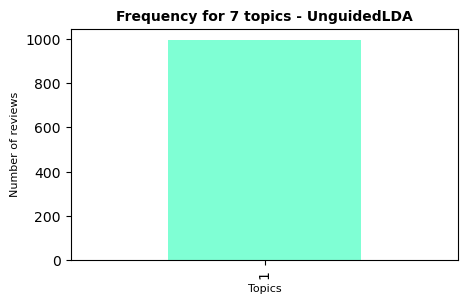

In [13]:
# graph the frequency of topics across all reviews
number_of_topics = frequency_table['Topic'].value_counts().sort_index()
number_of_topics.plot(kind = "bar", color = "aquamarine", figsize = (5,3))
plt.title("Frequency for 7 topics - UnguidedLDA", size = 10, fontweight="bold")
plt.xlabel("Topics", size = 8, fontweight="normal")
plt.ylabel("Number of reviews", size = 8, fontweight="normal")

For 7 topics, the result is really bad. The model assigns all review into only 1 topic (topic 1)

So next, we'll see if the model does better with 10 topics

In [50]:
# unguided LDA with 10 topics
model1, result1 = test_eta('auto', dictionary, ntopics=10)

Perplexity: -9.32
****************************************************************************************************
Topic 0: ['make', 'fast', 'take', 'avoid', 'like', 'funny', 'believable', 'special', 'easy', 'experience']
Topic 1: ['classic', 'share', 'charming', 'heart', 'sentiment', 'masterpiece', 'release', 'original', 'joy', 'race']
Topic 2: ['bad', 'story', 'wonderful', 'real', 'art', 'go', 'work', 'truly', 'show', 'far']
Topic 3: ['act', 'look', 'even', 'plot', 'end', 'also', 'drama', 'year', 'line', 'performance']
Topic 4: ['good', 'time', 'watch', 'well', 'scene', 'still', 'script', 'suck', 'waste', 'short']
Topic 5: ['really', 'dialogue', 'seem', 'lot', 'mess', 'keep', 'effect', 'beautiful', 'enough', 'serious']
Topic 6: ['see', 'think', 'recommend', 'get', 'play', 'never', 'actor', 'love', 'enjoy', 'become']
Topic 7: ['great', 'ever', 'write', 'know', 'thing', 'screen', 'pace', 'fail', 'writer', 'long']
Topic 8: ['character', 'music', 'subtle', 'come', 'highly', 'little',

In [51]:
# display the first 21 rows of the DataFrame with topics and probability for each review
result1.head(21)

,ID,Review,Topic,Probability
0,1,"A very, very, very slow-moving, aimless movie ...",0,0.042702
1,2,"A very, very, very slow-moving, aimless movie ...",2,0.160898
2,3,"A very, very, very slow-moving, aimless movie ...",3,0.172027
3,4,"A very, very, very slow-moving, aimless movie ...",4,0.322051
4,5,"A very, very, very slow-moving, aimless movie ...",5,0.040533
5,6,"A very, very, very slow-moving, aimless movie ...",6,0.076564
6,7,"A very, very, very slow-moving, aimless movie ...",7,0.038400
7,8,"A very, very, very slow-moving, aimless movie ...",8,0.126603
8,9,"A very, very, very slow-moving, aimless movie ...",9,0.014527
9,10,Not sure who was more lost - the flat characte...,0,0.038297


In [54]:
# assign the topic for each review by selecting the topic with highest probability
frequency_table1 = result1.loc[result1.groupby('Review')['Probability'].idxmax()]
frequency_table1.sort_values('ID', inplace=True)
frequency_table1

,ID,Review,Topic,Probability
3,4,"A very, very, very slow-moving, aimless movie ...",4,0.322051
12,13,Not sure who was more lost - the flat characte...,4,0.268747
20,21,Attempting artiness with black & white and cle...,3,0.501455
34,35,Very little music or anything to speak of.,8,0.347308
39,40,The best scene in the movie was when Gerardo i...,4,0.590056
...,...,...,...,...
8918,8919,I just got bored watching Jessice Lange take h...,4,0.376393
8927,8928,"Unfortunately, any virtue in this film's produ...",4,0.448228
8934,8935,"In a word, it is embarrassing.",2,0.312106
8943,8944,Exceptionally bad!,2,0.312115


In [55]:
# create frequency table
pd.crosstab(index=frequency_table1['Topic'], columns='Frequency') 

col_0,Frequency
Topic,
0,42
1,8
2,134
3,131
4,459
5,28
6,110
7,34
8,35


Text(0, 0.5, 'Number of reviews')

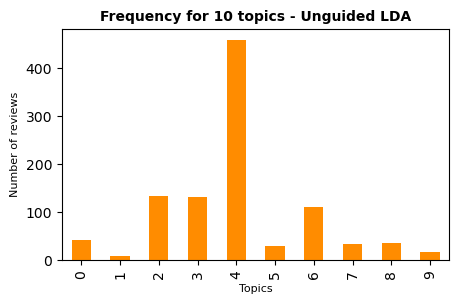

In [57]:
# graph the frequency of topics across all reviews
number_of_topics1 = frequency_table1['Topic'].value_counts().sort_index()
number_of_topics1.plot(kind = "bar", color = "darkorange", figsize = (5,3))
plt.title("Frequency for 10 topics - Unguided LDA", size = 10, fontweight="bold")
plt.xlabel("Topics", size = 8, fontweight="normal")
plt.ylabel("Number of reviews", size = 8, fontweight="normal")

As expected, for 10 topics, the result is a much better as the model could assign the reviews into 10 different topics. However, the majority of them is assigned into 1 topic (topic 4)

Since the results for unguided LDA aren’t so good, we can try to improve the result of 10 topics by running a guided LDA with predefined list of terms associated with each topic (using the list of keywords already manually extracted from part I) and recalculate all the steps above.

## 4.2 Guided LDA
We create a numpy matrix with the same number of rows and columns as topics and terms, respectively. We then populate that matrix with our prior distribution. We will use the list of words we manually extracted from file imdb_labelled.txt before:
* Plot / Story line: plot, lines, message, predictable, screenplay, content, character, conception, idea, moment, story
* Acting: character, acting, act, actor, actress, casting, cast, talented, co-star, leading, performance, convincing
* Cinematography / Directing: artiness, camera angles, scenes, cinematography, directing
* Music: music, song
* Effect / Post-production: editing, structure, cinema, graphics, effects
* Movie genres: game, series, horror, comedy, suspense
* Production / Budget: budget, cost, production
* Quality: waste, masterpiece, unfunny, generic, funny, regret, resounding, disappointed

In [59]:
def create_eta(priors, etadict, ntopics):
    eta = np.full(shape=(ntopics, len(etadict)), fill_value=1) # create a (ntopics, nterms) matrix and fill with 1
    for word, topic in priors.items(): # for each word in the list of priors
        keyindex = [index for index,term in etadict.items() if term==word] # look up the word in the dictionary
        if (len(keyindex)>0): # if it's in the dictionary
            eta[topic,keyindex[0]] = 1e7  # put a large number in there
    eta = np.divide(eta, eta.sum(axis=0)) # normalize so that the probabilities sum to 1 over all topics
    return eta

In [60]:
predefined_topic = {
   'plot':0, 'lines':0, 'line':0, 'message':0, 'predictable':0, 'screenplay':0, 'content':0, 'character':0, 'conception':0, 'idea':0, 'moment':0, 'story':0, 'write':0,
    'character':1, 'characters':1, 'acting':1, 'act':1, 'actor':1, 'actress':1, 'casting':1, 'cast':1, 'talented':1, 'star':1, 'leading':1, 'performance':1, 'convincing':1, 'portray':1, 'portrayal':1, 'perform':1,
    'artiness':2, 'camera':2, 'angles':2, 'scene':2, 'scenes':2, 'cinematography':2, 'direct':2, 'directing':2, 'art':2,
    'horror':3, 'comedy':3, 'cartoon':3,'game':3,'suspense':3,'series':3, 'drama':3,
    'budget':4, 'production':4,'cost':4,
    'waste':5, 'masterpiece':5, 'unfunny':5, 'generic':5, 'funny':5, 'regret':5, 'resounding':5, 'disappointed':5, 'recommend':5, 'boring':5,
    'music':6, 'song':6, 'songs':6, 
    'edit':7, 'cinema':7, 'structure':7, 'editing': 7,
    'graphics':8, 'effect':8, 'effects':8, 'special':8   
}
eta = create_eta(predefined_topic, dictionary, 10)

In [61]:
model2, result2 = test_eta(eta, dictionary, ntopics=10)

Perplexity: 12.57
****************************************************************************************************
Topic 0: ['story', 'wonderful', 'plot', 'also', 'write', 'line', 'pace', 'involve', 'predictable', 'many']
Topic 1: ['actor', 'suck', 'performance', 'way', 'excellent', 'people', 'use', 'become', 'actress', 'cast']
Topic 2: ['bad', 'scene', 'script', 'real', 'art', 'go', 'short', 'work', 'truly', 'screen']
Topic 3: ['act', 'even', 'drama', 'interesting', 'avoid', 'comedy', 'say', 'right', 'pretty', 'writer']
Topic 4: ['good', 'time', 'watch', 'waste', 'follow', 'find', 'lot', 'actually', 'definitely', 'whole']
Topic 5: ['recommend', 'funny', 'life', 'give', 'boring', 'fail', 'however', 'first', 'tell', 'cheap']
Topic 6: ['see', 'think', 'get', 'play', 'never', 'love', 'enjoy', 'year', 'music', 'seem']
Topic 7: ['make', 'great', 'well', 'ever', 'look', 'end', 'thing', 'like', 'hand', 'hole']
Topic 8: ['character', 'still', 'know', 'take', 'come', 'effect', 'little', 'fa

In [62]:
# display the first 21 rows of the DataFrame with topics and probability for each review
result2.head(21)

,ID,Review,Topic,Probability
0,1,"A very, very, very slow-moving, aimless movie ...",0,0.045762
1,2,"A very, very, very slow-moving, aimless movie ...",1,0.045359
2,3,"A very, very, very slow-moving, aimless movie ...",2,0.262174
3,4,"A very, very, very slow-moving, aimless movie ...",3,0.056706
4,5,"A very, very, very slow-moving, aimless movie ...",4,0.335568
5,6,"A very, very, very slow-moving, aimless movie ...",5,0.027220
6,7,"A very, very, very slow-moving, aimless movie ...",6,0.077087
7,8,"A very, very, very slow-moving, aimless movie ...",7,0.070405
8,9,"A very, very, very slow-moving, aimless movie ...",8,0.048521
9,10,"A very, very, very slow-moving, aimless movie ...",9,0.031197


In [63]:
# assign the topic for each review by selecting the topic with highest probability
frequency_table2 = result2.loc[result2.groupby('Review')['Probability'].idxmax()]
frequency_table2.sort_values('ID', inplace=True)
frequency_table2

,ID,Review,Topic,Probability
4,5,"A very, very, very slow-moving, aimless movie ...",4,0.335568
18,19,Not sure who was more lost - the flat characte...,8,0.314510
23,24,Attempting artiness with black & white and cle...,3,0.292560
38,39,Very little music or anything to speak of.,8,0.263201
44,45,The best scene in the movie was when Gerardo i...,4,0.401369
...,...,...,...,...
9957,9958,I just got bored watching Jessice Lange take h...,8,0.370668
9961,9962,"Unfortunately, any virtue in this film's produ...",2,0.405304
9971,9972,"In a word, it is embarrassing.",2,0.345535
9981,9982,Exceptionally bad!,2,0.345540


In [64]:
# create frequency table
pd.crosstab(index=frequency_table2['Topic'], columns='Frequency') 

col_0,Frequency
Topic,
0,57
1,59
2,239
3,74
4,171
5,42
6,133
7,115
8,71


Text(0, 0.5, 'Number of reviews')

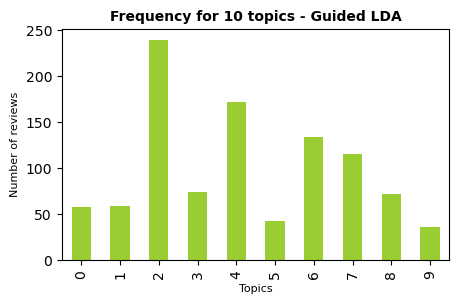

In [65]:
# graph the frequency of topics across all reviews
number_of_topics2 = frequency_table2['Topic'].value_counts().sort_index()
number_of_topics2.plot(kind = "bar", color = "yellowgreen", figsize = (5,3))
plt.title("Frequency for 10 topics - Guided LDA", size = 10, fontweight="bold")
plt.xlabel("Topics", size = 8, fontweight="normal")
plt.ylabel("Number of reviews", size = 8, fontweight="normal")

As you can see here, the distribution of 10 topics is much better across all reviews with guided LDA and using only noun and verb. And this is our final model.